In [ ]:
import pandas as pd
import keras
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Activation, AveragePooling2D, Add, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import model_from_json
import cv2
from keras.callbacks import ReduceLROnPlateau

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/shuffledrestrans.csv')
#df.head()

In [ ]:
#Assigning Names to Emotions in labels

num_classes = 5
width = 48
height = 48
# emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral", "Bored"]
# classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral", "Bored"))
emotion_labels = ["Angry","Happy", "Surprise", "Neutral", "Bored"]
classes=np.array(("Angry","Happy", "Surprise", "Neutral", "Bored"))
df.Usage.value_counts()

Training      26558
PublicTest     6553
Name: Usage, dtype: int64

In [ ]:
k = np.array(list(map(int,df.iloc[0,1].split(" "))),dtype='uint8').reshape((48,48))

In [ ]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['class'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['class'])

In [ ]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [ ]:
y_train= to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [ ]:
# augmentarea datelor pentru antrenare
datagen = ImageDataGenerator(
    # normalizarea pixelilor imaginilor
    rescale=1./255,
    # rotirea imaginilor cu până la 10 grade
    rotation_range = 10,
    # întoarcerea imaginilor după axa orizontală, la întâmplare
    horizontal_flip = True,
    # permutarea imaginilor cu până la 10% din dimensiuni pe orizontala
    width_shift_range=0.1,
    # permutarea imaginilor cu până la 10% din dimensiuni pe verticală
    height_shift_range=0.1,
    # umplerea golurilor cu valorile cele mai apropiate ale pixelilor
    fill_mode = 'nearest')

# augmentarea datelor pentru validare
testgen = ImageDataGenerator(
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 16

In [ ]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size)
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

<ipython-input-12-5cb2c153832b>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(330 + 1 + i)


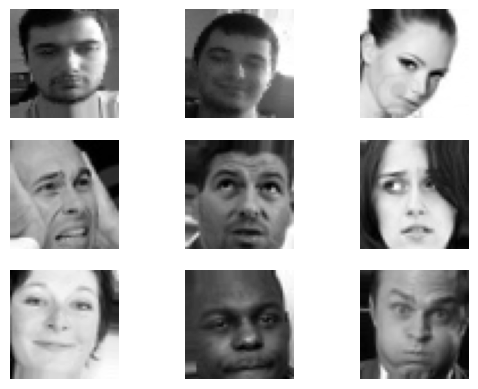

In [ ]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.axis('off')
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()
    break

In [ ]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 5

    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.2, name = 'drop1_1')(pool1_1)

    #the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.2, name = 'drop2_1')(pool2_1)

    # blocul 3, la nivelul căruia rețeaua începe să învețe tipare mai complexe
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    # declararea stratului convoluțional conv3_2, cu 256 de filtre
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    # introducerea unui strat de normalizare în loturi asupra stratului convoluțional conv_3_4
    conv3_4 = BatchNormalization()(conv3_4)
    # aplicarea regularizării prin introducerea unui strat de punere în comun
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    # aplicarea regularizării prin introducerea stratului de cădere
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

    #the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)

      #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(1024, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(1024, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_4)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.5, name = 'drop5_1')(pool5_1)

    # #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    # create model
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())

    return model


# def FER_Model(input_shape=(48,48,1)):
#     visible = Input(shape=input_shape, name='input')
#     num_classes = 8

#     # Block 1
#     x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(visible)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

#     # Block 2
#     x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

#     # Block 3
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#     # Classification block
#     x = Flatten(name='flatten')(x)
#     x = Dense(256, activation='relu', name='fc1')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(256, activation='relu', name='fc2')(x)
#     x = Dropout(0.5)(x)
#     ouput = Dense(num_classes, activation='softmax', name = 'output')(x)

#     # create model
#     model = Model(inputs =visible, outputs = ouput)
#     # summary layers
#     print(model.summary())

#     return model


# def VGG19_Model(input_shape=(48,48,1), num_classes=5):
#     visible = Input(shape=input_shape, name='input')

#     # Block 1
#     x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(visible)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

#     # Block 2
#     x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

#     # Block 3
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)  # Extra
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)  # Extra
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#     # Block 4
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)  # Extra
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#     # Block 5
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
#     x = MaxPooling2D((2, 2), strides=(1, 1), name='block5_pool')(x)  # change stride to prevent reducing to 1x1

#     # Classification block
#     x = Flatten(name='flatten')(x)
#     x = Dense(4096, activation='relu', name='fc1')(x)
#     x = Dropout(0.5)(x)
#     x = Dense(4096, activation='relu', name='fc2')(x)
#     x = Dropout(0.5)(x)
#     ouput = Dense(num_classes, activation='softmax', name = 'output')(x)

#     # create model
#     model = Model(inputs=visible, outputs=ouput)
#     # summary layers
#     print(model.summary())

#     return model


In [ ]:
model = FER_Model()
opt = Adam(learning_rate=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0     

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="modelrestrans.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, reduce_lr]

In [ ]:
num_epochs = 20
history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    callbacks=callbacks_list,
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

Epoch 1/20


<ipython-input-16-1a2a80b424ad>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_flow,



Epoch 1: val_accuracy improved from -inf to 0.46269, saving model to modelrestrans.h5
1659/1659 - 44s - loss: 1.6248 - accuracy: 0.3739 - val_loss: 1.3099 - val_accuracy: 0.4627 - lr: 1.0000e-04 - 44s/epoch - 26ms/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.46269 to 0.58630, saving model to modelrestrans.h5
1659/1659 - 31s - loss: 1.1883 - accuracy: 0.4797 - val_loss: 1.2032 - val_accuracy: 0.5863 - lr: 1.0000e-04 - 31s/epoch - 18ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.58630 to 0.61224, saving model to modelrestrans.h5
1659/1659 - 30s - loss: 1.0389 - accuracy: 0.5700 - val_loss: 1.2608 - val_accuracy: 0.6122 - lr: 1.0000e-04 - 30s/epoch - 18ms/step
Epoch 4/20

Epoch 4: val_accuracy improved from 0.61224 to 0.67038, saving model to modelrestrans.h5
1659/1659 - 30s - loss: 0.9251 - accuracy: 0.6289 - val_loss: 0.9312 - val_accuracy: 0.6704 - lr: 1.0000e-04 - 30s/epoch - 18ms/step
Epoch 5/20

Epoch 5: val_accuracy improved from 0.67038 to 0.69541, saving mod

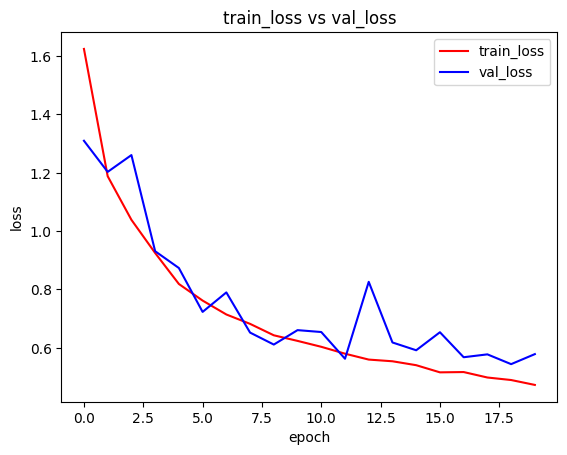

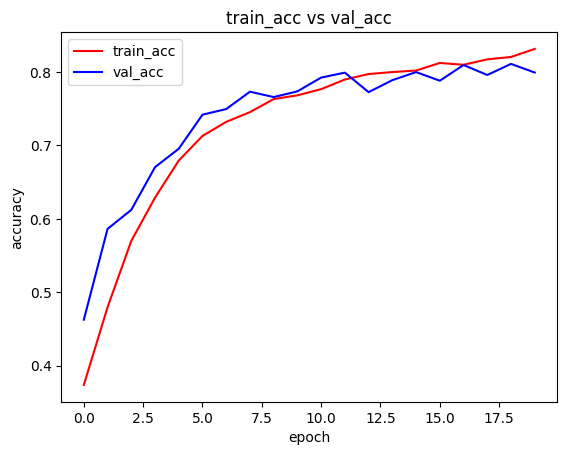

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

model.save('tweakedmodel.h5')

In [ ]:
num_epochs = 20
history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    callbacks=callbacks_list,
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

Epoch 1/20


<ipython-input-18-1a2a80b424ad>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_flow,



Epoch 1: val_accuracy improved from 0.81093 to 0.82085, saving model to modelrestrans.h5
1659/1659 - 34s - loss: 0.4733 - accuracy: 0.8288 - val_loss: 0.5425 - val_accuracy: 0.8208 - lr: 1.0000e-04 - 34s/epoch - 20ms/step
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.82085
1659/1659 - 32s - loss: 0.4629 - accuracy: 0.8350 - val_loss: 0.5383 - val_accuracy: 0.8208 - lr: 1.0000e-04 - 32s/epoch - 19ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.82085 to 0.82954, saving model to modelrestrans.h5
1659/1659 - 32s - loss: 0.4529 - accuracy: 0.8374 - val_loss: 0.5021 - val_accuracy: 0.8295 - lr: 1.0000e-04 - 32s/epoch - 19ms/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.82954
1659/1659 - 31s - loss: 0.4409 - accuracy: 0.8409 - val_loss: 0.6329 - val_accuracy: 0.8062 - lr: 1.0000e-04 - 31s/epoch - 19ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.82954
1659/1659 - 31s - loss: 0.4334 - accuracy: 0.8454 - val_loss: 0.5892 - val_accuracy: 0.8

In [ ]:
num_epochs = 20
history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    callbacks=callbacks_list,
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

Epoch 1/20


<ipython-input-19-1a2a80b424ad>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_flow,



Epoch 1: val_accuracy did not improve from 0.83366
1659/1659 - 31s - loss: 0.2687 - accuracy: 0.9034 - val_loss: 0.6316 - val_accuracy: 0.8331 - lr: 1.0000e-05 - 31s/epoch - 18ms/step
Epoch 2/20

Epoch 2: val_accuracy improved from 0.83366 to 0.83504, saving model to modelrestrans.h5
1659/1659 - 31s - loss: 0.2575 - accuracy: 0.9067 - val_loss: 0.6411 - val_accuracy: 0.8350 - lr: 1.0000e-05 - 31s/epoch - 19ms/step
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.83504
1659/1659 - 30s - loss: 0.2516 - accuracy: 0.9092 - val_loss: 0.6566 - val_accuracy: 0.8332 - lr: 1.0000e-05 - 30s/epoch - 18ms/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.83504
1659/1659 - 30s - loss: 0.2459 - accuracy: 0.9108 - val_loss: 0.6928 - val_accuracy: 0.8340 - lr: 1.0000e-05 - 30s/epoch - 18ms/step
Epoch 5/20

Epoch 5: val_accuracy improved from 0.83504 to 0.83595, saving model to modelrestrans.h5
1659/1659 - 30s - loss: 0.2470 - accuracy: 0.9111 - val_loss: 0.6562 - val_accuracy: 0.8

In [ ]:
num_epochs = 20
history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    callbacks=callbacks_list,
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

Epoch 1/20


<ipython-input-20-1a2a80b424ad>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_flow,



Epoch 1: val_accuracy did not improve from 0.83778
1659/1659 - 30s - loss: 0.2042 - accuracy: 0.9259 - val_loss: 0.7330 - val_accuracy: 0.8349 - lr: 1.0000e-06 - 30s/epoch - 18ms/step
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.83778
1659/1659 - 30s - loss: 0.2051 - accuracy: 0.9257 - val_loss: 0.7302 - val_accuracy: 0.8349 - lr: 1.0000e-06 - 30s/epoch - 18ms/step
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.83778
1659/1659 - 30s - loss: 0.1996 - accuracy: 0.9277 - val_loss: 0.7376 - val_accuracy: 0.8361 - lr: 1.0000e-06 - 30s/epoch - 18ms/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.83778
1659/1659 - 29s - loss: 0.2031 - accuracy: 0.9264 - val_loss: 0.7354 - val_accuracy: 0.8360 - lr: 1.0000e-06 - 29s/epoch - 18ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.83778
1659/1659 - 30s - loss: 0.1996 - accuracy: 0.9270 - val_loss: 0.7417 - val_accuracy: 0.8360 - lr: 1.0000e-06 - 30s/epoch - 18ms/step
Epoch 6/20

Epoch 6: val_accura

<Figure size 640x480 with 0 Axes>

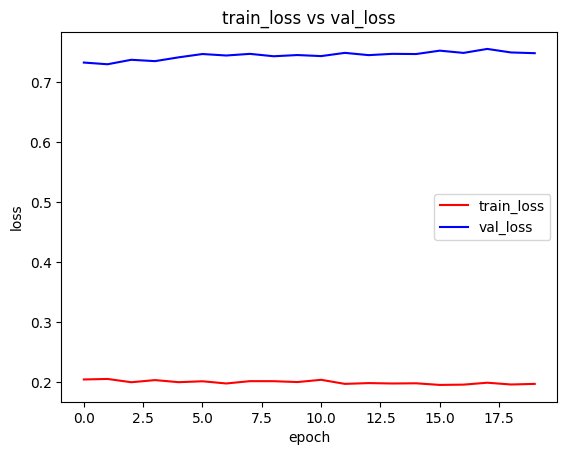

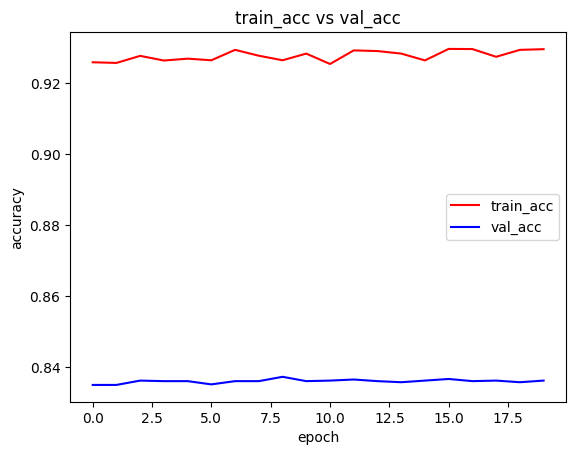

<Figure size 640x480 with 0 Axes>

In [ ]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [ ]:
model.save('fmodel.h5')

In [ ]:
num_epochs = 20
history = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    callbacks=callbacks_list,
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

model.save('final_model2.h5')

Epoch 1/20


<ipython-input-22-0381345d6622>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_flow,



Epoch 1: val_accuracy did not improve from 0.83778
1659/1659 - 30s - loss: 0.1979 - accuracy: 0.9280 - val_loss: 0.7537 - val_accuracy: 0.8363 - lr: 1.0000e-07 - 30s/epoch - 18ms/step
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.83778
1659/1659 - 30s - loss: 0.1992 - accuracy: 0.9280 - val_loss: 0.7526 - val_accuracy: 0.8352 - lr: 1.0000e-07 - 30s/epoch - 18ms/step
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.83778
1659/1659 - 29s - loss: 0.1967 - accuracy: 0.9285 - val_loss: 0.7520 - val_accuracy: 0.8356 - lr: 1.0000e-07 - 29s/epoch - 18ms/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.83778
1659/1659 - 29s - loss: 0.1904 - accuracy: 0.9300 - val_loss: 0.7540 - val_accuracy: 0.8361 - lr: 1.0000e-07 - 29s/epoch - 18ms/step
Epoch 5/20


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
print(len(X_test))
print(y_pred.shape)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
print(y_pred_classes.shape)
print(y_pred_classes.shape)
# Calculate F1 score
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')  # replace 'macro' with appropriate averaging method if needed
print('F1 Score: ', f1)

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print('Confusion Matrix: \n', cm)

157/157 [==============================] - 1s 3ms/step
5020
(5020, 8)
(5020,)
(5020,)
F1 Score:  0.0421607447189862
Confusion Matrix: 
 [[   1    0    0  463    0    1    2    0]
 [   0    0    0   56    0    0    0    0]
 [   0    0    0  495    0    0    1    0]
 [   0    0    0  981    0    1    2    0]
 [   0    0    0  649    0    1    3    0]
 [   0    0    0  590    0    0    0    0]
 [   0    0    0 1105    0    1    3    0]
 [   0    0    0  665    0    0    0    0]]
